<a href="https://colab.research.google.com/github/pankaj18/forecasting/blob/main/deepar/multiple_time_series_deepar2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade mxnet-cu101~=1.7
!pip install gluonts

     |████████████████████████████████| 356.7 MB 21 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 2.1 MB 7.5 MB/s 
     |████████████████████████████████| 10.1 MB 42.7 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.0 which is incompatible.


Download and unzip the data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip

--2021-08-02 11:14:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261335609 (249M) [application/x-httpd-php]
Saving to: ‘LD2011_2014.txt.zip’

LD2011_2014.txt.zip 100%[===================>] 249.23M  88.7MB/s    in 2.8s    

2021-08-02 11:14:21 (88.7 MB/s) - ‘LD2011_2014.txt.zip’ saved [261335609/261335609]



In [3]:
!unzip LD2011_2014.txt.zip

Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  


In [4]:
#!head LD2011_2014.txt

Import relevant librararies

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [7]:
df=pd.read_csv('LD2011_2014.txt',sep=';',parse_dates=True,index_col=0,decimal=',')

In [8]:
def understand_df(df):
  print(f"shape of df is:{df.shape}")
  print(df.head())
  print('categorical columns')
  print(df.select_dtypes(include="object").columns)
  print('numerical columns')
  print(df.select_dtypes(exclude="object").columns)
  print('Check Missing values in dataset')
  print(df.isnull().sum())

In [9]:
understand_df(df)

shape of df is:(140256, 370)
                     MT_001  MT_002  MT_003  ...  MT_368  MT_369  MT_370
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0
2011-01-01 01:00:00     0.0     0.0     0.0  ...     0.0     0.0     0.0
2011-01-01 01:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0

[5 rows x 370 columns]
categorical columns
Index([], dtype='object')
numerical columns
Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', length=370)
Check Missing values in dataset
MT_001    0
MT_002    0
MT_003    0
MT_004    0
MT_005    0
         ..
MT_366    0
MT_367    0
MT_368    0
MT_369    0
MT_370    0
Length:

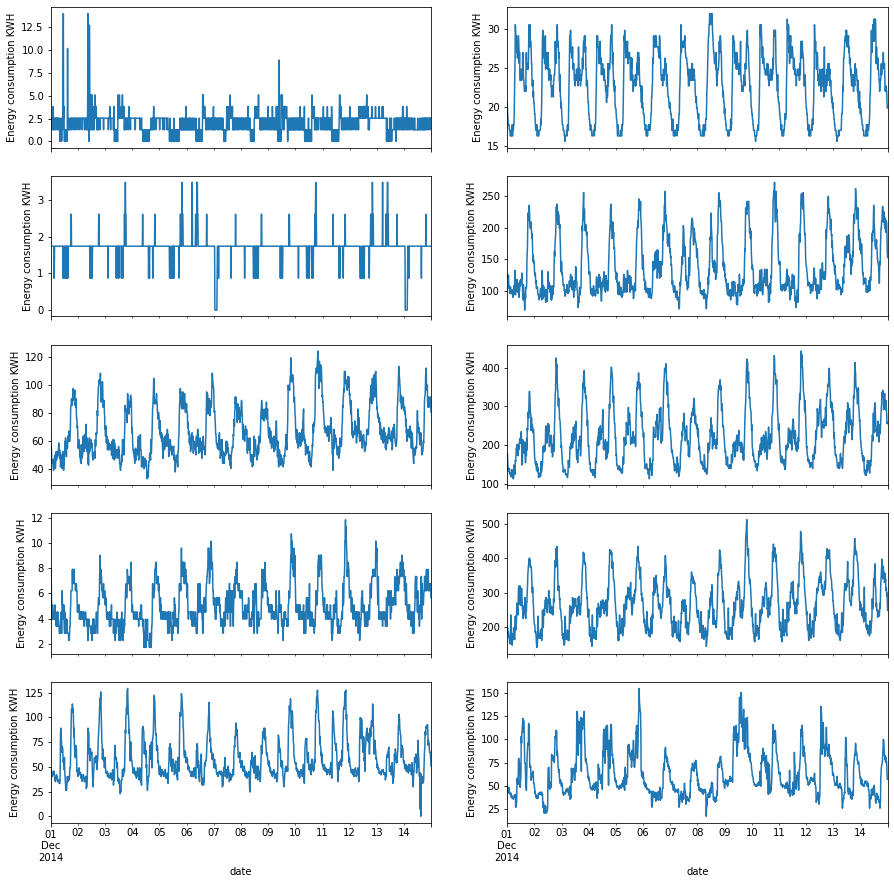

In [10]:
fig,axs=plt.subplots(nrows=5,ncols=2,sharex=True,figsize=(15,15))
axs=axs.ravel()
for i in range(10):
  df[df.columns[i]].loc["2014-12-01":"2014-12-14"].plot(ax=axs[i])
  axs[i].set_xlabel("date")
  axs[i].set_ylabel('Energy consumption KWH')

In [11]:
df_input=df.reset_index(drop=True).T.reset_index()

In [12]:
df_input.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,140216,140217,140218,140219,140220,140221,140222,140223,140224,140225,140226,140227,140228,140229,140230,140231,140232,140233,140234,140235,140236,140237,140238,140239,140240,140241,140242,140243,140244,140245,140246,140247,140248,140249,140250,140251,140252,140253,140254,140255
0,MT_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.269036,1.269036,1.269036,2.538071,3.807107,6.345178,2.538071,2.538071,2.538071,3.807107,2.538071,2.538071,2.538071,1.269036,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,2.538071,1.269036,2.538071,3.807107,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,2.538071,1.269036,2.538071
1,MT_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.027027,25.604552,27.027027,26.315789,29.160740,29.160740,29.871977,29.160740,29.160740,28.449502,28.449502,29.871977,29.160740,26.315789,27.738265,27.738265,29.160740,28.449502,29.160740,29.160740,28.449502,28.449502,27.027027,26.315789,25.604552,25.604552,23.470839,22.759602,23.470839,22.759602,22.048364,22.048364,22.048364,22.048364,22.048364,22.048364,21.337127,20.625889,21.337127,19.914651
2,MT_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.737619,0.868810,1.737619,1.737619,1.737619,1.737619,0.868810,1.737619,1.737619,1.737619,1.737619,1.737619,2.606429,1.737619,2.606429,3.475239,2.606429,2.606429,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619
3,MT_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,132.113821,128.048780,146.341463,144.308943,146.341463,144.308943,126.016260,140.243902,152.439024,162.601626,162.601626,164.634146,152.439024,160.569106,189.024390,205.284553,199.186992,205.284553,217.479675,215.447154,227.642276,205.284553,193.089431,195.121951,193.089431,189.024390,168.699187,162.601626,168.699187,160.569106,156.504065,164.634146,160.569106,162.601626,156.504065,150.406504,166.666667,162.601626,166.666667,178.861789
4,MT_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,73.170732,69.512195,57.317073,59.756098,60.975610,60.975610,62.195122,54.878049,63.414634,71.951220,75.609756,68.292683,63.414634,65.853659,74.390244,85.365854,87.804878,86.585366,89.024390,92.682927,102.439024,95.121951,91.463415,96.341463,91.463415,90.243902,90.243902,87.804878,87.804878,82.926829,86.585366,93.902439,87.804878,80.487805,85.365854,85.365854,81.707317,82.926829,85.365854,84.146341


In [13]:
ts_code=df_input['index'].astype('category').cat.codes.values
#ts_code

In [14]:
df_train=df_input.iloc[:,1:134999].values
df_test=df_input.iloc[:,134999:].values

In [15]:
df_train.shape

(370, 134998)

In [16]:
df_test.shape

(370, 5258)

In [17]:
df.index[0]

Timestamp('2011-01-01 00:15:00')

In [18]:
df.index[134997]

Timestamp('2014-11-07 05:30:00')

In [19]:
freq='15min'
start_train=pd.Timestamp('2011-01-01 00:15:00',freq=freq)
start_test=pd.Timestamp('2014-11-07 05:30:00',freq=freq)

In [20]:
# predict for 6 days: 4*24*6 
prediction_length=672


In [21]:
import mxnet as mx

In [22]:
estimator=DeepAREstimator(
    freq=freq,
    prediction_length=672,
    context_length=672,
    use_feat_static_cat=True,
    cardinality=[1],
    num_layers=1,
    num_cells=32,
    cell_type='lstm',
    trainer=Trainer(epochs=20,batch_size=32,ctx=mx.context.gpu())
)

In [23]:
df_train[0:8].shape

(8, 134998)

In [24]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [25]:
train_ds=ListDataset(
    [
     {FieldName.START:start_train,
     FieldName.TARGET:target,
     FieldName.FEAT_STATIC_CAT:fsc
     } for (target,fsc) in zip(df_train[0:10],ts_code[0:10].reshape(-1,1))
    ],
    freq=freq
)

In [26]:
test_ds=ListDataset(
    [
     {FieldName.START:start_test,
     FieldName.TARGET:target,
     FieldName.FEAT_STATIC_CAT:fsc
     } for (target,fsc) in zip(df_test[0:10],ts_code[0:10].reshape(-1,1))
    ],
    freq=freq
)

In [27]:
next(iter(train_ds))

{'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2011-01-01 00:15:00', freq='15T'),
 'target': array([0.       , 0.       , 0.       , ..., 2.5380712, 2.5380712,
        1.2690356], dtype=float32)}

In [28]:
predictor=estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:33<00:00,  1.48it/s, epoch=20/20, avg_epoch_loss=2.12]


In [29]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [30]:
forecast_it,ts_it=make_evaluation_predictions(test_ds,predictor,num_samples=100)

In [31]:
def plot_prob_forecast(ts_entry,forecast_entry):
  prediction_intervals=(80.0,95.0)
  legend=["observations","median_prediction"]+[f"{k}% prediction interval" for k in prediction_intervals ][::-1]
  plot_length=prediction_length
  fig,ax=plt.subplots(1,1,figsize=(10,6))
  ts_entry[-prediction_length:].plot(ax=ax)
  forecast_entry.plot(prediction_intervals=prediction_intervals,color='g')
  plt.grid(which='both')
  plt.legend(legend,loc="upper left")


In [32]:
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [33]:
tss=list(tqdm(ts_it,total=len(df_test)))
forecasts=list(tqdm(forecast_it,total=len(df_test)))

In [34]:
len(tss)

10

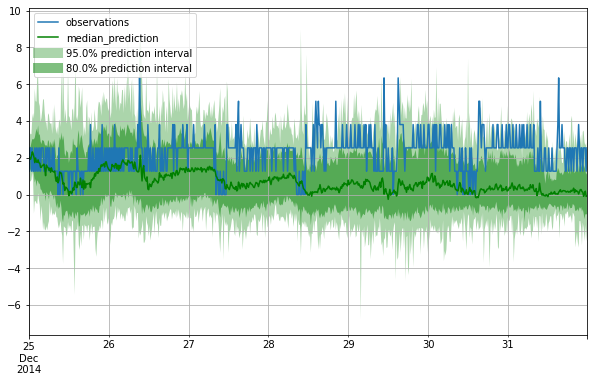

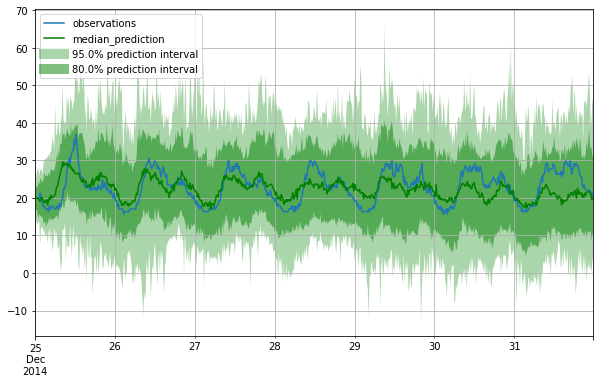

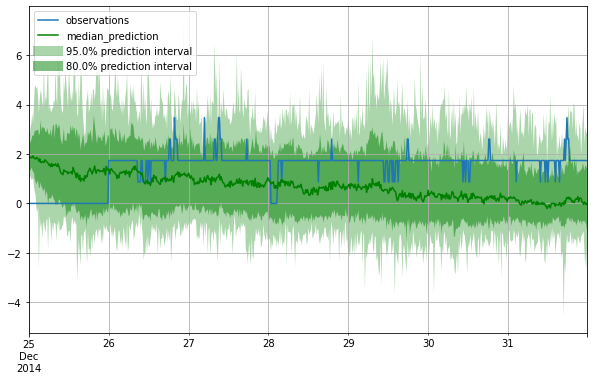

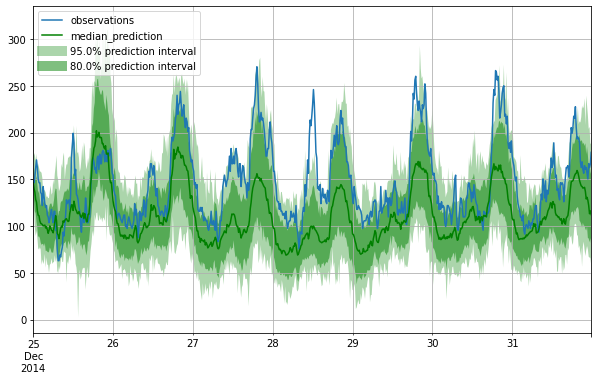

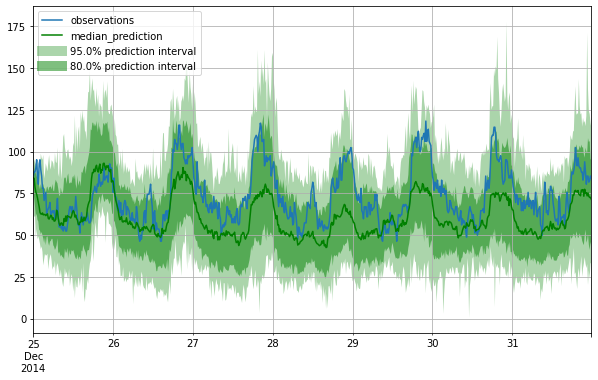

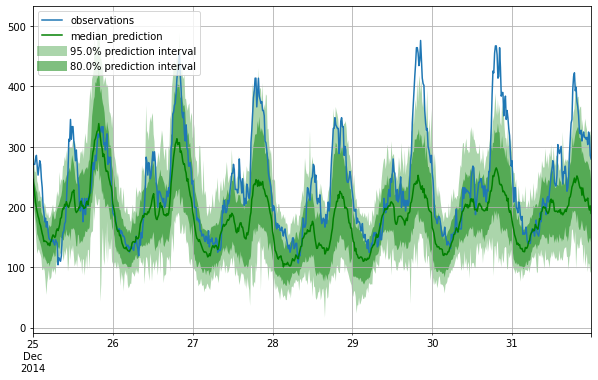

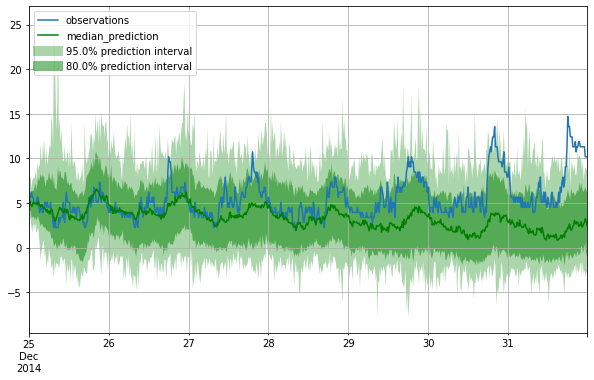

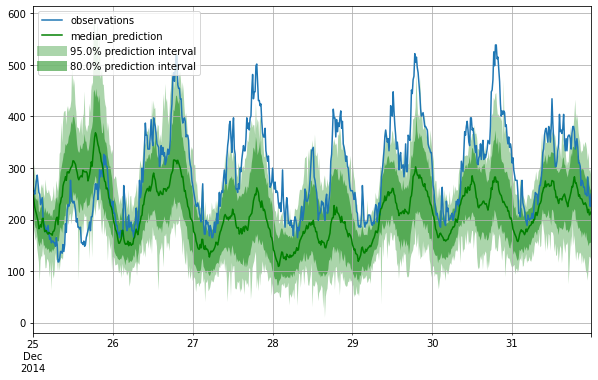

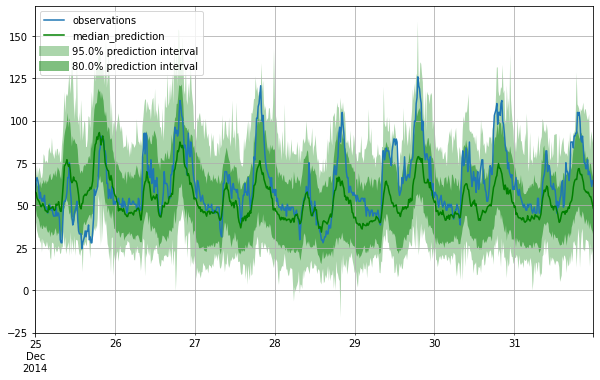

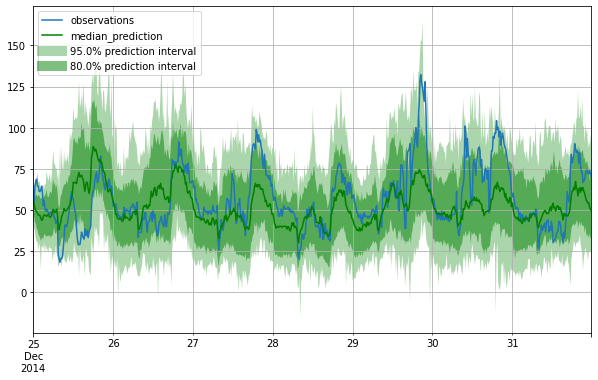

In [41]:
for i in tqdm(range(10)):
  ts_entry=tss[i]
  forecast_entry=forecasts[i]
  plot_prob_forecast(ts_entry,forecast_entry)

In [36]:
from gluonts.evaluation import Evaluator

In [39]:
evaluator=Evaluator(quantiles=[0.1,0.5,0.9])
agg_metrics,item_metrics=evaluator(iter(tss),iter(forecasts),num_series=len(df[0:10]))

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 17.15it/s]


In [40]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,3.516850,1120.236328,1513.959351,2.252916,0.931286,1.790018,0.690571,1.185069,9.855639,394.103866,0.004464,1120.236313,0.102679,597.731194,0.510417
1,NaN,12.401202,1887.412598,15320.056641,22.797703,1.305572,2.151278,0.122383,0.123344,29.768082,1426.667555,0.000000,1887.412685,0.520833,1401.985080,0.998512
2,NaN,1.409047,799.673706,984.361450,1.464824,0.203948,5.834781,0.661599,1.213660,27.592194,310.552600,0.053571,799.673734,0.165179,199.301293,0.787202
3,NaN,1806.904390,24523.437500,98455.281250,146.510835,16.799753,2.172247,0.234469,0.272952,11.056323,8872.789259,0.007440,24523.436691,0.084821,11986.855525,0.505952
4,NaN,238.883161,9154.480469,49303.656250,73.368536,7.521593,1.811151,0.174619,0.195877,10.319838,4361.907884,0.000000,9154.480309,0.127976,2370.052779,0.863095
5,NaN,5106.808036,37127.593750,157196.437500,233.923270,24.201930,2.282851,0.209852,0.241873,14.900570,13360.000482,0.008929,37127.592026,0.144345,22277.042599,0.563988
6,NaN,9.705873,1546.343994,3665.913086,5.455228,0.929394,2.475922,0.367850,0.498186,18.250500,733.000659,0.000000,1546.344048,0.163690,758.670408,0.818452
7,NaN,10879.538690,60846.023438,193720.546875,288.274623,26.564083,3.408538,0.302464,0.345998,25.361839,21062.780223,0.069940,60846.021759,0.107143,44517.501216,0.330357
8,NaN,248.183175,8635.994141,41779.718750,62.172201,8.849113,1.452257,0.200105,0.210374,8.849979,4193.709647,0.041667,8635.993666,0.181548,3168.044079,0.877976
9,NaN,241.319568,7959.025879,38359.140625,57.082055,18.548267,0.638539,0.210534,0.205929,4.203051,3668.953778,0.035714,7959.025570,0.349702,3692.426196,0.885417
